In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lkh
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [3]:
"""Capacited Vehicles Routing Problem (CVRP)."""

def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    demands = np.ones(distance_matrix.shape[0])
    demands[0] = 0
    data["demands"] = np.int64(demands)
    data["num_vehicles"] = int((distance_matrix.shape[0]-1)//8+1)
    data["vehicle_capacities"] = np.int64(np.ones(data["num_vehicles"])*8)
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    recorder = np.zeros((500,200))
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            if node_index != 0:
                recorder[vehicle_id,int(route_load)] = node_index
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    return total_distance,recorder

def CVRP_solver(distance_matrix):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix)
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        np.int64(data["vehicle_capacities"]),  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        distance,recorder = print_solution(data, manager, routing, solution)
        return distance, recorder

In [4]:
def write_tsplib95(distance_matrix, filename="output.tsp"):
    # write the distance matrix to a file in TSPLIB95 format
    with open(filename, 'w') as file:
        # Write the header
        file.write("NAME: MyDistanceMatrix\n")
        file.write("TYPE: CVRP\n")
        file.write("COMMENT: This file was generated by write_tsplib95.py\n")
        file.write(f"DIMENSION: {(len(distance_matrix))}\n")
        file.write("EDGE_WEIGHT_TYPE: EXPLICIT\n")
        file.write("EDGE_WEIGHT_FORMAT: FULL_MATRIX\n")
        # VEHICLES is the number of node//8+1
        file.write(f"VEHICLES: {(len(distance_matrix)//8+1)}\n")
        file.write("CAPACITY: 8\n")
        file.write("EDGE_WEIGHT_SECTION\n")
        # Write the distance matrix
        for row in distance_matrix:
            file.write(' '.join(map(str, row)) + '\n')
        file.write("DEMAND_SECTION\n")
        for i in range(len(distance_matrix)):
            if i == 0:
                file.write(f"{i+1} 0\n")
            else:
                file.write(f"{i+1} 1\n")
        file.write("EOF\n")
        
    print(f"TSPLIB95 file '{filename}' created successfully.")

def lkh_optimization(distance_matrix):
    # solve the VRP using LKH
    write_tsplib95(distance_matrix, filename="output.vrp")
    problem = lkh.LKHProblem.load('output.vrp')
    solver_path = '../src/LKH-3.0.9/LKH'
    route = lkh.solve(solver_path, problem=problem, max_trials=1000, runs=10)
    # remove the first element of the first route
    route[0] = route[0][1:]

    return route
    

In [5]:
def random_choice(total_elements, chosen_elements):
    '''
    total_elements: total number of elements in the array
    chosen_elements: number of elements to be chosen
    '''
    a = np.zeros(total_elements)
    random_vector = np.random.rand(chosen_elements)
    random_vector = random_vector.round(2)
    random_vector = random_vector / random_vector.sum(axis=0, keepdims=1)
    a[:chosen_elements] = random_vector
    np.random.shuffle(a)
    return a
def random_choose_candidate(num_candidate,total_dim,non_zeros_dim): 
    '''
    num_candidate: number of candidate to be chosen
    total_candidate: total number of candidates
    chosen_elements: number of elements to be chosen
    '''
    # repeat the random_choice function for num_candidate times
    lower_bound = np.zeros(total_dim)
    upper_bound = np.ones(total_dim)
    a = np.zeros((num_candidate,total_dim))
    for i in range(num_candidate):
        while True:
            candidate = random_choice(total_dim,non_zeros_dim)
            if np.all((candidate >= lower_bound) & (candidate <= upper_bound)):
                a[i,:] = candidate
                break
    return a.round(2)
a= random_choose_candidate(96,96,3)
a.shape

(96, 96)

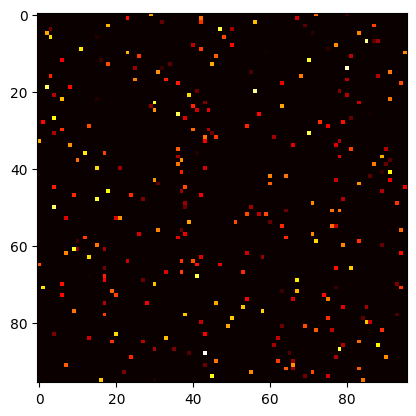

(287, 2)


In [6]:
# read the data
positions = a
# turn the non-zero values into 1
#plot the heatmap
plt.imshow(positions, cmap='hot', interpolation='nearest')
plt.show()
# find the non-zero positions as (dest, source) pairs
non_zero_pos = np.argwhere(positions)
print(non_zero_pos.shape)

In [7]:
def calculate_distance(pos_matrix):
    # given a non-zero position matrix, calculate the distance between each pair
    distance_matrix = np.zeros((pos_matrix.shape[0], pos_matrix.shape[0]))
    for i in range(pos_matrix.shape[0]):
        for j in range(pos_matrix.shape[0]):
            is_neighbor_dest = ((pos_matrix[i, 0]//8) == (pos_matrix[j, 0]//8)) and ((abs(pos_matrix[i, 0] - pos_matrix[j, 0]) <=2) and (abs(pos_matrix[i, 0] - pos_matrix[j, 0])>0))
            is_neighbor_source = ((pos_matrix[i, 1]//8) == (pos_matrix[j, 1]//8)) and ((abs(pos_matrix[i, 1] - pos_matrix[j, 1]) <=2) and (abs(pos_matrix[i, 1] - pos_matrix[j, 1])>0))
            if is_neighbor_dest and is_neighbor_source:
                distance_matrix[i, j] = 0
            elif is_neighbor_dest or is_neighbor_source:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = 2
    distance_matrix = np.vstack((np.zeros(distance_matrix.shape[0]), distance_matrix))
    distance_matrix = np.hstack((np.zeros((distance_matrix.shape[0], 1)), distance_matrix))
    return distance_matrix

In [8]:
def pair_distance_calculator(pos1,pos2):
    is_neighbor_dest = ((pos1[0]//8) == (pos2[0]//8)) and ((abs(pos1[0] - pos2[0]) <=2) and (abs(pos1[0] - pos2[0])>0))
    is_neighbor_source = ((pos1[1]//8) == (pos2[1]//8)) and ((abs(pos1[1] - pos2[1]) <=2) and (abs(pos1[1] - pos2[1])>0))
    if is_neighbor_dest and is_neighbor_source:
        return 0
    elif is_neighbor_dest or is_neighbor_source:
        return 1
    else:
        return 2

def distance_calculator(non_zero_pos):
    distance_sum = 0
    for i in range(non_zero_pos.shape[0]//8):
        # take the first 8 elements
        temp = non_zero_pos[i*8:(i+1)*8]
        temp_sum = 0
        for j in range(7):
            #print(temp[j],temp[j+1])
            temp_sum += pair_distance_calculator(temp[j],temp[j+1])
        #print(temp_sum)
        distance_sum += temp_sum
    
    return distance_sum


In [9]:
stat = []
for i in range(1,5):
    positions = random_choose_candidate(96,96,i)
    non_zero_pos = np.argwhere(positions)
    distance_matrix = calculate_distance(non_zero_pos)
    optimized_distance,recorder = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(non_zero_pos)
    lkh_routes = lkh_optimization(distance_matrix)
    lkh_distance = 0
    for i in range(len(lkh_routes)):
        lkh_route = np.array(lkh_routes[i])
        print(lkh_route)
        for j in range (lkh_route.shape[0]-1):
            lkh_distance += pair_distance_calculator(non_zero_pos[lkh_route[j]-1],non_zero_pos[lkh_route[j+1]-1])
    print(lkh_distance)
    stat.append((i,non_optimized_distance,optimized_distance))
stat = np.array(stat)

Objective: 77
Route for vehicle 0:
 0 Load(0) ->  8 Load(1) ->  0 Load(1)
Distance of the route: 0m
Load of the route: 1

Route for vehicle 1:
 0 Load(0) ->  7 Load(1) ->  6 Load(2) ->  5 Load(3) ->  4 Load(4) ->  3 Load(5) ->  2 Load(6) ->  1 Load(7) ->  0 Load(7)
Distance of the route: 6m
Load of the route: 7

Route for vehicle 2:
 0 Load(0) ->  16 Load(1) ->  15 Load(2) ->  14 Load(3) ->  12 Load(4) ->  13 Load(5) ->  11 Load(6) ->  10 Load(7) ->  9 Load(8) ->  0 Load(8)
Distance of the route: 4m
Load of the route: 8

Route for vehicle 3:
 0 Load(0) ->  24 Load(1) ->  23 Load(2) ->  22 Load(3) ->  21 Load(4) ->  20 Load(5) ->  19 Load(6) ->  18 Load(7) ->  17 Load(8) ->  0 Load(8)
Distance of the route: 7m
Load of the route: 8

Route for vehicle 4:
 0 Load(0) ->  32 Load(1) ->  31 Load(2) ->  30 Load(3) ->  29 Load(4) ->  28 Load(5) ->  27 Load(6) ->  26 Load(7) ->  25 Load(8) ->  0 Load(8)
Distance of the route: 6m
Load of the route: 8

Route for vehicle 5:
 0 Load(0) ->  40 Load(1

AssertionError: ../src/LKH-3.0.9/LKH not found.

In [9]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='optimized')
plt.plot(stat[:,0],stat[:,2],label='non-optimized')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [10]:
route = lkh_optimization(distance_matrix)


TSPLIB95 file 'output.vrp' created successfully.


NameError: name 'lkh' is not defined

In [11]:
recorder = recorder[~np.all(recorder == 0, axis=1)]
recorder = recorder[:, ~np.all(recorder == 0, axis=0)]
recorder

NameError: name 'recorder' is not defined

In [12]:
# Create a boolean mask that is True for rows containing any zero
mask = (recorder == 0).any(axis=1)
# Get the rows not containing zero and the rows containing zero
non_zero_rows = recorder[~mask]
zero_rows = recorder[mask]
# Concatenate the two arrays to get a new array where rows containing zero are at the end
recorder = np.concatenate([non_zero_rows, zero_rows])
recorder.shape

NameError: name 'recorder' is not defined

In [13]:
def pair_distance_calculator(pos1,pos2):
    is_neighbor_dest = ((pos1[0]//8) == (pos2[0]//8)) and ((abs(pos1[0] - pos2[0]) <=2) and (abs(pos1[0] - pos2[0])>0))
    is_neighbor_source = ((pos1[1]//8) == (pos2[1]//8)) and ((abs(pos1[1] - pos2[1]) <=2) and (abs(pos1[1] - pos2[1])>0))
    if is_neighbor_dest and is_neighbor_source:
        return 0
    elif is_neighbor_dest or is_neighbor_source:
        return 1
    else:
        return 2

In [14]:
"""Capacited Vehicles Routing Problem (CVRP)."""

def create_data_model(distance_matrix=distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    demands = np.ones(distance_matrix.shape[0])
    demands[0] = 0
    data["demands"] = demands
    data["num_vehicles"] = (distance_matrix.shape[0]-1)//8+1
    data["vehicle_capacities"] = np.ones(data["num_vehicles"])*8
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    recorder = np.zeros((48,10))
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            if node_index != 0:
                recorder[vehicle_id,int(route_load)] = node_index
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    return recorder

"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data["demands"][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data["vehicle_capacities"],  # vehicle maximum capacities
    True,  # start cumul to zero
    "Capacity",
)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    recorder = print_solution(data, manager, routing, solution)


NameError: name 'pywrapcp' is not defined

In [15]:
distance_sum = 0
for i in range(non_zero_pos.shape[0]//8):
    # take the first 8 elements
    temp = non_zero_pos[i*8:(i+1)*8]
    temp_sum = 0
    for j in range(7):
        print(temp[j],temp[j+1])
        temp_sum += pair_distance_calculator(temp[j],temp[j+1])
    print(temp_sum)
    distance_sum += temp_sum


[ 0 65] [ 1 32]
[ 1 32] [ 2 22]
[ 2 22] [ 3 31]
[ 3 31] [ 4 61]
[ 4 61] [ 5 29]
[ 5 29] [ 6 44]
[ 6 44] [ 7 90]
7
[ 8 46] [ 9 40]
[ 9 40] [10 16]
[10 16] [11 54]
[11 54] [12 27]
[12 27] [13 78]
[13 78] [14  4]
[14  4] [15 46]
7
[16 38] [17 10]
[17 10] [18 26]
[18 26] [19 76]
[19 76] [20 87]
[20 87] [21 64]
[21 64] [22 31]
[22 31] [23 44]
7
[24 16] [25 53]
[25 53] [26  6]
[26  6] [27 29]
[27 29] [28 40]
[28 40] [29 16]
[29 16] [30 56]
[30 56] [31  0]
7
[32 48] [33 28]
[33 28] [34 81]
[34 81] [35 27]
[35 27] [36 63]
[36 63] [37 47]
[37 47] [38 50]
[38 50] [39 76]
7
[40 39] [41 31]
[41 31] [42 74]
[42 74] [43 44]
[43 44] [44 91]
[44 91] [45  1]
[45  1] [46  9]
[46  9] [47 53]
7
[48 58] [49 31]
[49 31] [50 25]
[50 25] [51 44]
[51 44] [52 83]
[52 83] [53 64]
[53 64] [54 24]
[54 24] [55 70]
7
[56  8] [57  2]
[57  2] [58 47]
[58 47] [59 39]
[59 39] [60 44]
[60 44] [61 51]
[61 51] [62 86]
[62 86] [63 11]
7
[64 42] [65 39]
[65 39] [66  2]
[66  2] [67 25]
[67 25] [68 51]
[68 51] [69 29]
[69 29] 